# Tutorial 2 - RNN Time Series

In this notebook, we will predict the weather temperature. 

In [124]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Read the Dataset

In [125]:
import pandas as pd

weather = pd.read_csv('weather.csv')

weather.head()

,date,hour,NO2,CO,O3,NO,PM2.5,PM10,Air Temp.,Air Hum.,Air Pres.
0,4/25/2021,0,0.039817,0.080700,-0.000867,0.009800,0.2,5.040000,25.795000,99.9,1011.980000
1,4/25/2021,1,0.035900,0.092217,-0.000267,0.009833,0.2,6.293333,25.445000,99.9,1012.131667
2,4/25/2021,2,0.028083,0.062750,0.002517,0.012883,0.2,5.501667,25.223333,99.9,1012.365000
3,4/25/2021,3,0.025633,0.042300,0.004550,0.014233,0.2,4.201667,25.075000,99.9,1012.276667
4,4/25/2021,4,0.023717,0.036883,0.006267,0.015417,0.2,5.365000,24.928333,99.9,1012.030000


In [126]:
# Convert the temp to Fahrenheit:

weather['Air Temp F'] = weather['Air Temp.']*1.8 + 32

In [127]:
weather

,date,hour,NO2,CO,O3,NO,PM2.5,PM10,Air Temp.,Air Hum.,Air Pres.,Air Temp F
0,4/25/2021,0,0.039817,0.080700,-0.000867,0.009800,0.200,5.040000,25.795000,99.900,1011.980000,78.431
1,4/25/2021,1,0.035900,0.092217,-0.000267,0.009833,0.200,6.293333,25.445000,99.900,1012.131667,77.801
2,4/25/2021,2,0.028083,0.062750,0.002517,0.012883,0.200,5.501667,25.223333,99.900,1012.365000,77.402
3,4/25/2021,3,0.025633,0.042300,0.004550,0.014233,0.200,4.201667,25.075000,99.900,1012.276667,77.135
4,4/25/2021,4,0.023717,0.036883,0.006267,0.015417,0.200,5.365000,24.928333,99.900,1012.030000,76.871
...,...,...,...,...,...,...,...,...,...,...,...,...
7952,4/19/2022,19,0.007500,0.135750,0.035250,0.044000,2.150,9.275000,28.375000,39.175,1016.000000,83.075
7953,4/19/2022,20,0.024000,0.145750,0.025250,0.035000,2.525,16.100000,28.575000,37.275,1015.550000,83.435
7954,4/19/2022,21,0.013400,0.147200,0.038800,0.022200,2.260,12.980000,28.440000,32.740,1015.340000,83.192
7955,4/19/2022,22,0.023000,0.126000,0.039000,0.014000,2.350,11.375000,28.150000,33.250,1015.600000,82.670


In [128]:
#Drop the columns we don't need

weather = weather.drop(['NO2', 'CO', 'O3', 'NO', 'PM2.5', 'PM10', 'Air Temp.',
              'Air Hum.', 'Air Pres.'], axis=1)

In [129]:
weather

,date,hour,Air Temp F
0,4/25/2021,0,78.431
1,4/25/2021,1,77.801
2,4/25/2021,2,77.402
3,4/25/2021,3,77.135
4,4/25/2021,4,76.871
...,...,...,...
7952,4/19/2022,19,83.075
7953,4/19/2022,20,83.435
7954,4/19/2022,21,83.192
7955,4/19/2022,22,82.670


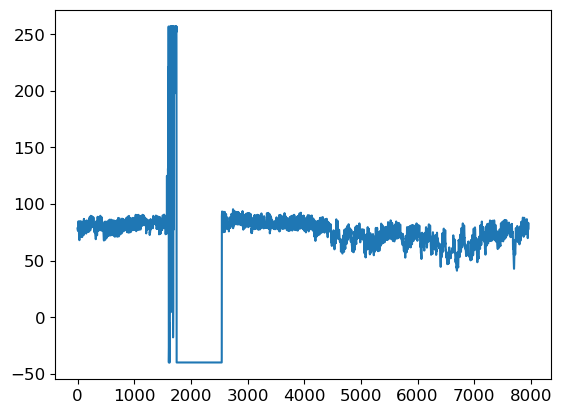

In [130]:
#Plot temp

plt.plot(weather['Air Temp F'])
plt.show()

# Data Cleanup

In [131]:
# Values higher than 100 degrees are probably incorrect readings

weather[weather['Air Temp F']>100]

,date,hour,Air Temp F
1578,6/29/2021,21,124.865
1582,6/30/2021,1,108.674
1595,6/30/2021,14,112.001
1596,6/30/2021,15,131.294
1597,6/30/2021,16,128.849
...,...,...,...
1742,7/6/2021,17,256.820
1743,7/6/2021,18,256.820
1744,7/6/2021,19,251.894
1745,7/6/2021,20,256.820


In [132]:
# Convert all values higher than 100 degrees to null values

weather['Air Temp F'] = np.where(weather['Air Temp F']>100, np.nan, weather['Air Temp F'])

In [133]:
# Values lower than 30 degrees are probably incorrect readings. Convert them to null

weather['Air Temp F'] = np.where(weather['Air Temp F']<30, np.nan, weather['Air Temp F'])

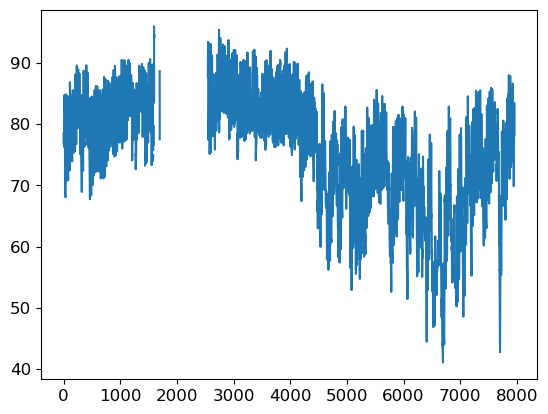

In [134]:
plt.plot(weather['Air Temp F'])
plt.show()

In [135]:
# Remove all null values

weather = weather.dropna().reset_index(drop=True)

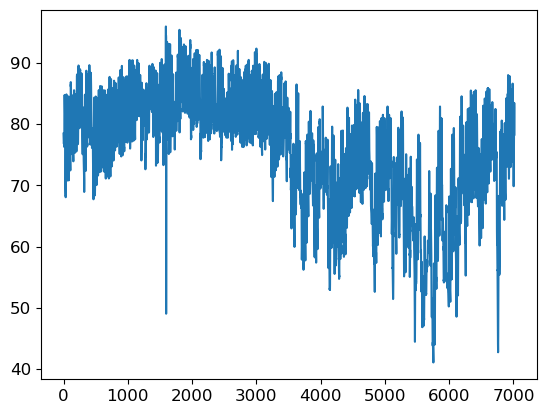

In [136]:
plt.plot(weather['Air Temp F'])
plt.show()

## RESHAPE the data set!

In [137]:
weather.shape

(7017, 3)

In [138]:
# Note that not all days have 24 readings. Some are missing.

weather.shape[0]/24

292.375

In [ ]:
weather.groupby(['date']).count()

In [139]:
# Find the reading count for each day

hour_count = pd.DataFrame(weather.groupby(['date']).count()['hour'])

hour_count

,hour
date,
1/1/2022,24
1/10/2022,24
1/11/2022,24
1/12/2022,24
1/13/2022,24
...,...
9/5/2021,24
9/6/2021,24
9/7/2021,24


In [140]:
# Find the reading counts that are less than 24

hour_count[hour_count['hour']<24]

,hour
date,
3/18/2022,7
4/11/2022,9
4/14/2022,10
6/21/2021,21
6/29/2021,23
6/30/2021,16
7/1/2021,1
7/2/2021,3
7/3/2021,3


In [141]:
# Identify the dates of these records

hour_count[hour_count['hour']<24].index.values

array(['3/18/2022', '4/11/2022', '4/14/2022', '6/21/2021', '6/29/2021',
       '6/30/2021', '7/1/2021', '7/2/2021', '7/3/2021', '7/4/2021',
       '8/10/2021'], dtype=object)

In [142]:
# Find the corresponding index values in the original data set

indexes = weather[weather['date'].isin(hour_count[hour_count['hour']<24].index.values)]

indexes

,date,hour,Air Temp F
1368,6/21/2021,0,84.386
1369,6/21/2021,1,84.137
1370,6/21/2021,2,83.993
1371,6/21/2021,3,83.549
1372,6/21/2021,4,83.210
...,...,...,...
6892,4/14/2022,19,83.732
6893,4/14/2022,20,82.715
6894,4/14/2022,21,81.590
6895,4/14/2022,22,82.085


In [143]:
# Remove these rows from the data set.

weather = weather.drop(indexes.index, axis=0).reset_index(drop=True)

weather.shape

(6912, 3)

In [144]:
weather.head()

,date,hour,Air Temp F
0,4/25/2021,0,78.431
1,4/25/2021,1,77.801
2,4/25/2021,2,77.402
3,4/25/2021,3,77.135
4,4/25/2021,4,76.871


In [145]:
# All remaining days have 24 readings (for 24 hours)
# There are a total of 288 days

weather.shape[0]/24

288.0

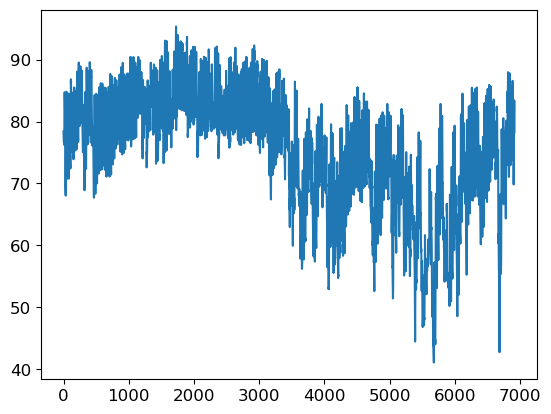

In [146]:
plt.plot(weather['Air Temp F'])
plt.show()

In [147]:
# Re-organize the data set by day and hours

temp = np.array(weather['Air Temp F']).reshape(288,24)

temp

array([[78.431     , 77.801     , 77.40199999, ..., 82.54700001,
        81.716     , 79.196     ],
       [76.02200001, 73.121     , 71.68699999, ..., 84.82699999,
        84.57499999, 82.52900001],
       [80.843     , 78.87500001, 77.05099999, ..., 84.52700001,
        83.99899999, 82.44199999],
       ...,
       [78.26      , 77.54      , 77.495     , ..., 83.98999999,
        83.3       , 79.736     ],
       [78.305     , 77.63      , 77.432     , ..., 84.245     ,
        83.084     , 79.376     ],
       [77.27      , 76.136     , 75.29      , ..., 83.192     ,
        82.67      , 78.26      ]])

In [148]:
# Convert to dataframe

temp_df = pd.DataFrame(temp, columns=np.arange(0,24,1))

temp_df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,78.431,77.801,77.402,77.135,76.871,76.814,76.892,76.925,76.580,76.343,...,81.584,81.575,82.445,84.731,84.272,83.252,83.447,82.547,81.716,79.196
1,76.022,73.121,71.687,70.664,69.560,68.864,68.603,68.360,68.360,68.267,...,75.500,77.594,79.691,81.458,83.012,84.080,84.323,84.827,84.575,82.529
2,80.843,78.875,77.051,74.675,73.499,72.950,72.221,71.330,71.048,70.766,...,77.222,79.241,80.933,81.602,82.478,83.795,84.146,84.527,83.999,82.442
3,80.576,78.731,76.739,74.819,73.829,73.052,72.575,71.876,71.306,70.793,...,77.657,79.562,81.014,81.848,82.955,83.813,83.996,84.437,82.913,80.210
4,78.632,77.618,76.040,75.278,74.918,74.561,73.859,73.127,72.785,72.575,...,79.859,82.376,85.808,86.831,86.108,86.459,86.003,84.902,84.413,81.434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,76.910,76.145,75.590,75.380,75.245,74.525,74.750,74.300,74.030,73.040,...,83.300,84.920,81.428,83.210,83.750,85.400,86.225,87.980,86.540,76.784
284,75.200,77.585,77.060,76.055,74.948,74.030,73.400,72.500,71.915,71.600,...,77.108,79.916,83.012,83.930,83.948,86.000,87.215,87.800,86.540,80.168
285,78.260,77.540,77.495,77.540,77.540,76.730,75.920,75.245,74.525,73.400,...,80.330,82.625,84.695,85.640,85.460,84.992,84.470,83.990,83.300,79.736
286,78.305,77.630,77.432,77.135,77.360,76.640,76.505,75.980,75.065,74.120,...,80.810,83.444,84.155,83.435,80.510,86.585,85.235,84.245,83.084,79.376


# Reshape for Standardizing Data

In [149]:
# Let's create a single sequence (i.e., feature) for standardization

temp_1feature = np.array(temp_df).ravel().reshape(-1,1)

temp_1feature.shape

(6912, 1)

In [150]:
temp_1feature

array([[78.431     ],
       [77.801     ],
       [77.40199999],
       ...,
       [83.192     ],
       [82.67      ],
       [78.26      ]])

## Standardize the values

In [151]:
# Next, standardize

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

temp_std = scaler.fit_transform(temp_1feature)

## Reshape the data back to 24-hour format

In [152]:
temp_reshaped = temp_std.reshape(288,24)

temp_reshaped.shape

(288, 24)

In [153]:
#Pandas version of the reshaped data

pd.DataFrame(temp_reshaped, columns=np.arange(0,24,1))

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.391232,0.325683,0.284169,0.256388,0.228920,0.222990,0.231105,0.234539,0.198643,0.173984,...,0.719288,0.718351,0.808871,1.046720,0.998963,0.892836,0.913125,0.819484,0.733022,0.470827
1,0.140586,-0.161251,-0.310453,-0.416891,-0.531758,-0.604174,-0.631330,-0.656613,-0.656613,-0.666289,...,0.086274,0.304145,0.522329,0.706178,0.867865,0.978986,1.004269,1.056708,1.030489,0.817611
2,0.642190,0.437428,0.247649,0.000436,-0.121922,-0.179043,-0.254892,-0.347597,-0.376938,-0.406279,...,0.265440,0.475509,0.651554,0.721161,0.812305,0.949333,0.985853,1.025494,0.970558,0.808559
3,0.614410,0.422445,0.215186,0.015419,-0.087587,-0.168430,-0.218060,-0.290788,-0.350094,-0.403470,...,0.310700,0.508907,0.659982,0.746756,0.861934,0.951206,0.970246,1.016130,0.857565,0.576329
4,0.412145,0.306642,0.142458,0.063175,0.025719,-0.011425,-0.084465,-0.160627,-0.196210,-0.218060,...,0.539809,0.801692,1.158777,1.265216,1.189991,1.226511,1.179066,1.064511,1.013633,0.703681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.232978,0.153383,0.095638,0.073788,0.059742,-0.015171,0.008239,-0.038581,-0.066674,-0.169679,...,0.897830,1.066384,0.703057,0.888466,0.944651,1.116326,1.202164,1.384764,1.234938,0.219868
284,0.055060,0.303209,0.248585,0.144019,0.028840,-0.066674,-0.132222,-0.225864,-0.286730,-0.319505,...,0.253579,0.545740,0.867865,0.963379,0.965252,1.178754,1.305169,1.366036,1.234938,0.571959
285,0.373440,0.298527,0.293845,0.298527,0.298527,0.214250,0.129973,0.059742,-0.015171,-0.132222,...,0.588814,0.827599,1.042974,1.141297,1.122569,1.073876,1.019564,0.969622,0.897830,0.527011
286,0.378122,0.307891,0.287290,0.256388,0.279799,0.204886,0.190840,0.136216,0.041014,-0.057309,...,0.638756,0.912813,0.986789,0.911876,0.607543,1.239620,1.099159,0.996153,0.875356,0.489555


# Split the Data

**In certain cases, we cannot use a random split. For example, if we are trying to predict the stock market, we cannot use a random split. We need to use a chronological split.**

BUT, keep in mind if we have something like hourly readings of dayly temperature, we can use a random split on days, but the sequence of the temperature within the day is important to remain sequential.

In this case, we are using a random spli because each day as an independent sample.

In [154]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(temp_reshaped, test_size=0.3)

# if we neede to maintain the ordering of the data, we can use the following code to split the data
#split_point = int(len(temp_reshaped)*0.7)
#train, test = temp_reshaped[:split_point], temp_reshaped[split_point:]

In [155]:
train.shape

(201, 24)

In [156]:
train[:2]

array([[ 0.39123163,  0.32568283,  0.28416859,  0.25638839,  0.22892032,
         0.22298971,  0.23110528,  0.23453878,  0.19864301,  0.17398418,
         0.16649289,  0.17273563,  0.24827282,  0.45771685,  0.71928778,
         0.71835137,  0.80887114,  1.04671965,  0.99896266,  0.89283603,
         0.91312495,  0.8194838 ,  0.73302181,  0.47082661],
       [ 0.1405855 , -0.16125112, -0.31045268, -0.41689145, -0.53175792,
        -0.60417373, -0.63132967, -0.65661278, -0.65661278, -0.66628903,
        -0.68907504, -0.51490251, -0.25895005, -0.09882369,  0.08627364,
         0.30414537,  0.52232924,  0.70617802,  0.86786506,  0.97898589,
         1.00426899,  1.05670804,  1.03048851,  0.81761098]])

In [157]:
test.shape

(87, 24)

In [158]:
test[:2]

array([[-0.72216158, -0.86262329, -0.85794124, -0.93285415, -1.08267998,
        -0.95158238, -0.98435678, -1.03585941, -1.08267998, -1.17632113,
        -1.2559161 , -1.29337256, -1.29337256, -1.01244913, -0.48337666,
        -0.12285825, -0.05730945,  0.00823935,  0.09251638,  0.58413239,
         0.60286062,  0.57008622, -0.06199151, -0.39441757],
       [-0.53019723, -0.58638192, -0.6425666 , -0.69875129, -0.76430009,
        -0.87666947, -0.91412592, -1.00776707, -1.09672616, -1.17632113,
        -1.22782376, -1.31210079, -1.3542393 , -0.96562855, -0.59106397,
        -0.25395585, -0.19308911, -0.02453505,  0.01292141,  0.49049125,
         0.65436325,  0.4951733 ,  0.02228552, -0.33355083]])

# Create Input and Target values

The first 23 hours will be input to predict the 24th hour reading (i.e., target)

In [159]:
# The first 23 columns (from 0 to 22) are inputs

train_inputs = train[:,:23]


pd.DataFrame(train_inputs, columns=np.arange(0,23,1))

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.391232,0.325683,0.284169,0.256388,0.228920,0.222990,0.231105,0.234539,0.198643,0.173984,...,0.457717,0.719288,0.718351,0.808871,1.046720,0.998963,0.892836,0.913125,0.819484,0.733022
1,0.140586,-0.161251,-0.310453,-0.416891,-0.531758,-0.604174,-0.631330,-0.656613,-0.656613,-0.666289,...,-0.098824,0.086274,0.304145,0.522329,0.706178,0.867865,0.978986,1.004269,1.056708,1.030489
2,0.642190,0.437428,0.247649,0.000436,-0.121922,-0.179043,-0.254892,-0.347597,-0.376938,-0.406279,...,0.041244,0.265440,0.475509,0.651554,0.721161,0.812305,0.949333,0.985853,1.025494,0.970558
3,0.614410,0.422445,0.215186,0.015419,-0.087587,-0.168430,-0.218060,-0.290788,-0.350094,-0.403470,...,0.071915,0.310700,0.508907,0.659982,0.746756,0.861934,0.951206,0.970246,1.016130,0.857565
4,0.412145,0.306642,0.142458,0.063175,0.025719,-0.011425,-0.084465,-0.160627,-0.196210,-0.218060,...,0.235163,0.539809,0.801692,1.158777,1.265216,1.189991,1.226511,1.179066,1.064511,1.013633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,-0.815803,-0.848577,-0.848577,-0.862623,-0.886034,-0.871987,-0.881352,-0.918808,-0.956264,-0.960946,...,-1.143547,-1.124818,-1.059270,-0.759618,-0.108812,-0.188407,-0.464648,-0.754936,-0.914126,-0.932854
197,-1.101408,-1.106090,-1.115454,-1.124818,-1.199731,-1.344875,-1.447880,-1.475973,-1.522793,-1.466609,...,-1.578978,-1.461927,-1.405742,-1.279326,-1.166957,-1.110772,-0.900080,-0.984357,-1.007767,-1.410424
198,-1.705394,-1.733486,-1.784989,-1.803717,-1.817763,-1.813081,-1.780307,-1.850537,-1.925450,-1.939496,...,-2.131461,-1.869266,-1.429152,-1.279326,-0.717480,-0.530197,-0.567654,-0.286730,-0.492741,-1.106090
199,-1.658573,-1.770942,-1.752214,-1.710076,-1.766260,-1.784989,-1.733486,-1.696029,-1.625799,-1.738168,...,-1.583660,-1.358921,-0.900080,-0.647249,-0.361643,-0.061992,0.504537,0.462399,0.359394,-0.225864


## Add one more dimension to make it ready for RNNs

See here for more details: https://keras.io/layers/recurrent/, and https://shiva-verma.medium.com/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e


In [160]:
train_inputs

array([[ 3.91231634e-01,  3.25682833e-01,  2.84168591e-01, ...,
         9.13124948e-01,  8.19483803e-01,  7.33021812e-01],
       [ 1.40585504e-01, -1.61251120e-01, -3.10452678e-01, ...,
         1.00426899e+00,  1.05670804e+00,  1.03048851e+00],
       [ 6.42189902e-01,  4.37427933e-01,  2.47648545e-01, ...,
         9.85852903e-01,  1.02549432e+00,  9.70558182e-01],
       ...,
       [-1.70539360e+00, -1.73348594e+00, -1.78498857e+00, ...,
        -2.86730254e-01, -4.92740772e-01, -1.10609027e+00],
       [-1.65857302e+00, -1.77094240e+00, -1.75221417e+00, ...,
         4.62398904e-01,  3.59393645e-01, -2.25863510e-01],
       [-8.29848893e-01, -9.74992668e-01, -1.04054147e+00, ...,
         4.95173305e-01,  4.85809190e-01, -1.12476250e-03]])

In [161]:
train_inputs.shape 

(201, 23)

In [162]:
#Create an additional dimension for train

train_x = train_inputs[:,:,np.newaxis]

train_x.shape 

(201, 23, 1)

In [163]:
train_x

array([[[ 3.91231634e-01],
        [ 3.25682833e-01],
        [ 2.84168591e-01],
        ...,
        [ 9.13124948e-01],
        [ 8.19483803e-01],
        [ 7.33021812e-01]],

       [[ 1.40585504e-01],
        [-1.61251120e-01],
        [-3.10452678e-01],
        ...,
        [ 1.00426899e+00],
        [ 1.05670804e+00],
        [ 1.03048851e+00]],

       [[ 6.42189902e-01],
        [ 4.37427933e-01],
        [ 2.47648545e-01],
        ...,
        [ 9.85852903e-01],
        [ 1.02549432e+00],
        [ 9.70558182e-01]],

       ...,

       [[-1.70539360e+00],
        [-1.73348594e+00],
        [-1.78498857e+00],
        ...,
        [-2.86730254e-01],
        [-4.92740772e-01],
        [-1.10609027e+00]],

       [[-1.65857302e+00],
        [-1.77094240e+00],
        [-1.75221417e+00],
        ...,
        [ 4.62398904e-01],
        [ 3.59393645e-01],
        [-2.25863510e-01]],

       [[-8.29848893e-01],
        [-9.74992668e-01],
        [-1.04054147e+00],
        ...,
        

## Set the target

In [164]:
# The last column (23) is TARGET

train_target = train[:,-1]


pd.DataFrame(train_target, columns=['23'])

,23
0,0.470827
1,0.817611
2,0.808559
3,0.576329
4,0.703681
...,...
196,-1.073316
197,-1.597706
198,-1.461927
199,-0.577018


## Repeat for TEST

In [165]:
test.shape

(87, 24)

In [166]:
# The first 23 columns (from 0 to 22) are inputs

test_inputs = test[:,:23]

In [167]:
#Create an additional dimension for test

test_x = test_inputs[:,:,np.newaxis]

test_x.shape 

(87, 23, 1)

In [168]:
# The last column (23) is TARGET

test_target = test[:,-1]


pd.DataFrame(test_target, columns=['23'])

,23
0,-0.394418
1,-0.333551
2,-0.038581
3,-0.033899
4,-0.197771
...,...
82,0.219868
83,0.571959
84,0.527011
85,0.489555


# A normal (cross-sectional) NN

This model assumes that the data is NOT a time-series data set. It treats the data as cross-sectional and the columns being independent of each other.

In [169]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[23, 1]),
    keras.layers.Dense(23, activation='relu'),
    keras.layers.Dense(1, activation=None)
    
])

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=100)

Epoch 1/100


2023-04-16 20:21:36.970981: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


7/7 [==============================] - 0s 947us/step - loss: 4.0862
Epoch 2/100
7/7 [==============================] - 0s 513us/step - loss: 2.9169
Epoch 3/100
7/7 [==============================] - 0s 610us/step - loss: 1.9966
Epoch 4/100
7/7 [==============================] - 0s 610us/step - loss: 1.3181
Epoch 5/100
7/7 [==============================] - 0s 634us/step - loss: 0.8027
Epoch 6/100
7/7 [==============================] - 0s 577us/step - loss: 0.4838
Epoch 7/100
7/7 [==============================] - 0s 593us/step - loss: 0.2987
Epoch 8/100
7/7 [==============================] - 0s 554us/step - loss: 0.1959
Epoch 9/100
7/7 [==============================] - 0s 600us/step - loss: 0.1520
Epoch 10/100
7/7 [==============================] - 0s 563us/step - loss: 0.1309
Epoch 11/100
7/7 [==============================] - 0s 550us/step - loss: 0.1221
Epoch 12/100
7/7 [==============================] - 0s 588us/step - loss: 0.1138
Epoch 13/100
7/7 [==============================]

### Predictions

In [170]:
#Predict:
y_pred = model.predict(test_x)

3/3 [==============================] - 0s 657us/step


In [171]:
# Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [172]:
comparison

,actual,predicted
0,70.880,72.621986
1,71.465,72.710640
2,74.300,72.533974
3,74.345,74.491722
4,72.770,72.985847
...,...,...
82,76.784,83.607979
83,80.168,82.447960
84,79.736,81.543015
85,79.376,82.124344


In [173]:
mean_squared_error(comparison['actual'], comparison['predicted'])

8.192542823689777

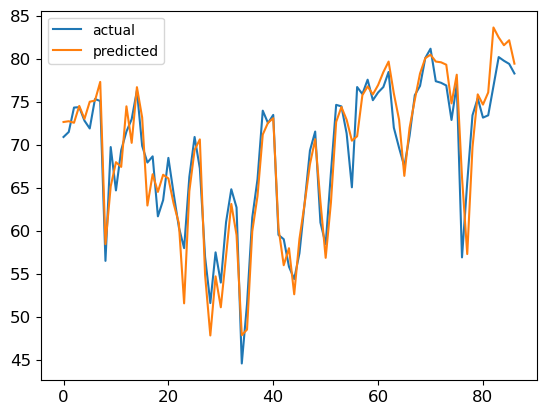

In [174]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# Simple RNN

Simplest recurrent neural network

In [175]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, activation='relu', input_shape=[23, 1]),
    keras.layers.Dense(1, activation=None)
])

In [176]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
7/7 [==============================] - 0s 3ms/step - loss: 0.2996
Epoch 2/30
7/7 [==============================] - 0s 2ms/step - loss: 0.2000
Epoch 3/30
7/7 [==============================] - 0s 2ms/step - loss: 0.1421
Epoch 4/30
7/7 [==============================] - 0s 2ms/step - loss: 0.1184
Epoch 5/30
7/7 [==============================] - 0s 2ms/step - loss: 0.0965
Epoch 6/30
7/7 [==============================] - 0s 2ms/step - loss: 0.0753
Epoch 7/30
7/7 [==============================] - 0s 2ms/step - loss: 0.0541
Epoch 8/30
7/7 [==============================] - 0s 2ms/step - loss: 0.0382
Epoch 9/30
7/7 [==============================] - 0s 2ms/step - loss: 0.0325
Epoch 10/30
7/7 [==============================] - 0s 2ms/step - loss: 0.0289
Epoch 11/30
7/7 [==============================] - 0s 2ms/step - loss: 0.0272
Epoch 12/30
7/7 [==============================] - 0s 2ms/step - loss: 0.0263
Epoch 13/30
7/7 [==============================] - 0s 2ms/step - loss: 0.

### Predictions

In [177]:
#Predict:
y_pred = model.predict(test_x)

3/3 [==============================] - 0s 2ms/step


In [178]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [179]:
comparison

,actual,predicted
0,70.880,71.839500
1,71.465,72.316452
2,74.300,73.880508
3,74.345,75.316231
4,72.770,73.103333
...,...,...
82,76.784,82.919823
83,80.168,82.747139
84,79.736,81.304237
85,79.376,80.363937


In [180]:
mean_squared_error(comparison['actual'], comparison['predicted'])

4.104162607408866

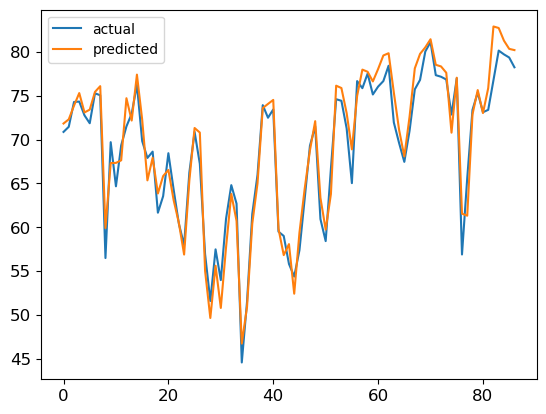

In [181]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

## Simple RNN with more layers

**Be careful: when stacking RNN layers, you have to set "return_sequences" to True. This enables the layer to send a "sequence" of values to the next layer -- jut like how it uses a sequence of values for training. However, if the output of RNN is sent to a DENSE layer, then a single value should be sent. That's why there is no "return sequences" right before DENSE layers.**

In [182]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=True, input_shape=[23, 1]),
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [183]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
7/7 [==============================] - 1s 5ms/step - loss: 1.2629
Epoch 2/30
7/7 [==============================] - 0s 3ms/step - loss: 0.4840
Epoch 3/30
7/7 [==============================] - 0s 3ms/step - loss: 0.3949
Epoch 4/30
7/7 [==============================] - 0s 3ms/step - loss: 0.3364
Epoch 5/30
7/7 [==============================] - 0s 3ms/step - loss: 0.2890
Epoch 6/30
7/7 [==============================] - 0s 3ms/step - loss: 0.2416
Epoch 7/30
7/7 [==============================] - 0s 3ms/step - loss: 0.1957
Epoch 8/30
7/7 [==============================] - 0s 3ms/step - loss: 0.1476
Epoch 9/30
7/7 [==============================] - 0s 3ms/step - loss: 0.0918
Epoch 10/30
7/7 [==============================] - 0s 3ms/step - loss: 0.0479
Epoch 11/30
7/7 [==============================] - 0s 3ms/step - loss: 0.0456
Epoch 12/30
7/7 [==============================] - 0s 3ms/step - loss: 0.0371
Epoch 13/30
7/7 [==============================] - 0s 3ms/step - loss: 0.

### Predictions

In [184]:
#Predict:
y_pred = model.predict(test_x)


3/3 [==============================] - 0s 3ms/step


In [185]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [186]:
comparison

,actual,predicted
0,70.880,71.622398
1,71.465,71.812515
2,74.300,73.091164
3,74.345,75.449379
4,72.770,72.949974
...,...,...
82,76.784,83.322777
83,80.168,83.066162
84,79.736,81.707802
85,79.376,80.817917


In [187]:
mean_squared_error(comparison['actual'], comparison['predicted'])

5.337214243992969

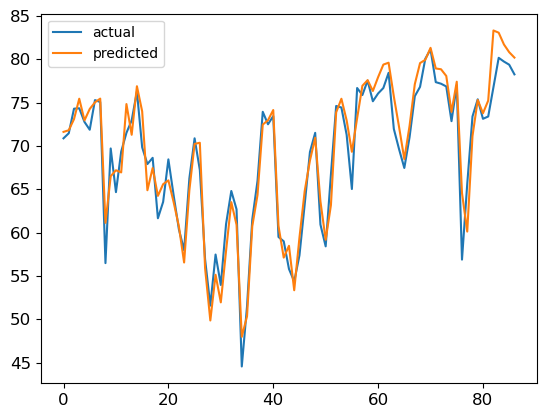

In [188]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# LSTM with one layer

In [189]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='relu', input_shape=[23, 1]),
    keras.layers.Dense(1, activation=None)
])

In [190]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
7/7 [==============================] - 1s 5ms/step - loss: 0.4738
Epoch 2/30
7/7 [==============================] - 0s 3ms/step - loss: 0.3197
Epoch 3/30
7/7 [==============================] - 0s 3ms/step - loss: 0.2068
Epoch 4/30
7/7 [==============================] - 0s 3ms/step - loss: 0.1426
Epoch 5/30
7/7 [==============================] - 0s 3ms/step - loss: 0.1366
Epoch 6/30
7/7 [==============================] - 0s 4ms/step - loss: 0.1023
Epoch 7/30
7/7 [==============================] - 0s 3ms/step - loss: 0.0693
Epoch 8/30
7/7 [==============================] - 0s 3ms/step - loss: 0.0640
Epoch 9/30
7/7 [==============================] - 0s 3ms/step - loss: 0.0600
Epoch 10/30
7/7 [==============================] - 0s 3ms/step - loss: 0.0578
Epoch 11/30
7/7 [==============================] - 0s 3ms/step - loss: 0.0511
Epoch 12/30
7/7 [==============================] - 0s 3ms/step - loss: 0.0540
Epoch 13/30
7/7 [==============================] - 0s 3ms/step - loss: 0.

### Predictions

In [191]:
#Predict:
y_pred = model.predict(test_x)


3/3 [==============================] - 0s 4ms/step


In [192]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [193]:
mean_squared_error(comparison['actual'], comparison['predicted'])

5.855036675281357

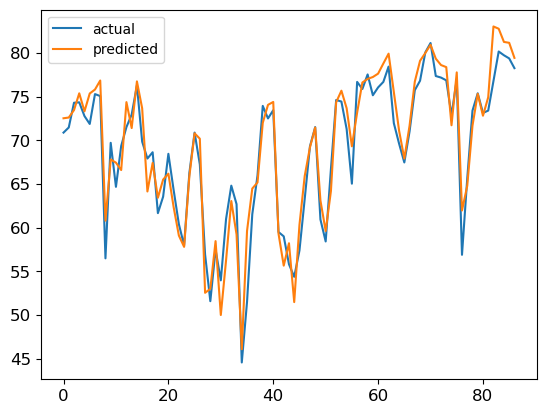

In [194]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# LSTM with more layers

In [195]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='tanh', return_sequences=True, input_shape=[23, 1]),
    keras.layers.LSTM(32, activation='tanh', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [196]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
7/7 [==============================] - 1s 11ms/step - loss: 0.5497
Epoch 2/30
7/7 [==============================] - 0s 9ms/step - loss: 0.2189
Epoch 3/30
7/7 [==============================] - 0s 8ms/step - loss: 0.1221
Epoch 4/30
7/7 [==============================] - 0s 8ms/step - loss: 0.1065
Epoch 5/30
7/7 [==============================] - 0s 8ms/step - loss: 0.0826
Epoch 6/30
7/7 [==============================] - 0s 8ms/step - loss: 0.0816
Epoch 7/30
7/7 [==============================] - 0s 8ms/step - loss: 0.0772
Epoch 8/30
7/7 [==============================] - 0s 8ms/step - loss: 0.0753
Epoch 9/30
7/7 [==============================] - 0s 8ms/step - loss: 0.0751
Epoch 10/30
7/7 [==============================] - 0s 8ms/step - loss: 0.0739
Epoch 11/30
7/7 [==============================] - 0s 8ms/step - loss: 0.0723
Epoch 12/30
7/7 [==============================] - 0s 7ms/step - loss: 0.0725
Epoch 13/30
7/7 [==============================] - 0s 8ms/step - loss: 0

### Predictions

In [197]:
#Predict:
y_pred = model.predict(test_x)

3/3 [==============================] - 0s 4ms/step


In [198]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [199]:
mean_squared_error(comparison['actual'], comparison['predicted'])

9.655561728139237

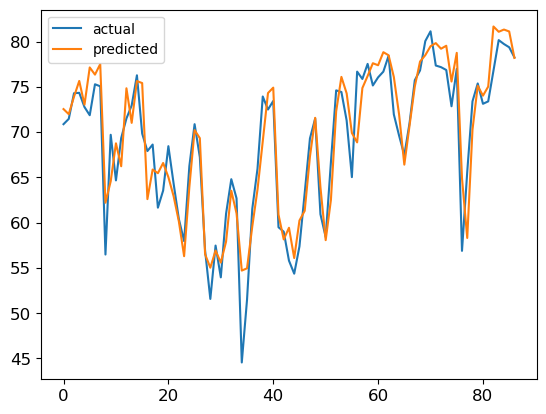

In [200]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# GRU (with more layers)

In [201]:
model = keras.models.Sequential([
    keras.layers.GRU(32, activation='relu', return_sequences=True, input_shape=[23, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [202]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='RMSprop')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
7/7 [==============================] - 1s 9ms/step - loss: 0.5801
Epoch 2/30
7/7 [==============================] - 0s 6ms/step - loss: 0.3624
Epoch 3/30
7/7 [==============================] - 0s 6ms/step - loss: 0.2125
Epoch 4/30
7/7 [==============================] - 0s 6ms/step - loss: 0.1101
Epoch 5/30
7/7 [==============================] - 0s 6ms/step - loss: 0.0660
Epoch 6/30
7/7 [==============================] - 0s 6ms/step - loss: 0.0567
Epoch 7/30
7/7 [==============================] - 0s 6ms/step - loss: 0.0547
Epoch 8/30
7/7 [==============================] - 0s 6ms/step - loss: 0.0555
Epoch 9/30
7/7 [==============================] - 0s 6ms/step - loss: 0.0544
Epoch 10/30
7/7 [==============================] - 0s 6ms/step - loss: 0.0536
Epoch 11/30
7/7 [==============================] - 0s 6ms/step - loss: 0.0531
Epoch 12/30
7/7 [==============================] - 0s 6ms/step - loss: 0.0525
Epoch 13/30
7/7 [==============================] - 0s 6ms/step - loss: 0.

### Predictions

In [203]:
#Predict:
y_pred = model.predict(test_x)

3/3 [==============================] - 0s 3ms/step


In [204]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [205]:
mean_squared_error(comparison['actual'], comparison['predicted'])

7.944369484406921

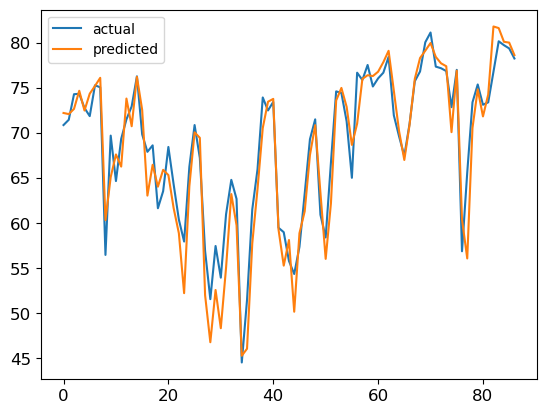

In [206]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# Conv1D

### Last Layer: GRU (you can change it to SimpleRNN or LSTM as well)

In [207]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=3, strides=1, padding="valid", input_shape=[23, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=True),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [208]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
7/7 [==============================] - 1s 10ms/step - loss: 0.5268
Epoch 2/30
7/7 [==============================] - 0s 8ms/step - loss: 0.3181
Epoch 3/30
7/7 [==============================] - 0s 9ms/step - loss: 0.1979
Epoch 4/30
7/7 [==============================] - 0s 8ms/step - loss: 0.1797
Epoch 5/30
7/7 [==============================] - 0s 7ms/step - loss: 0.1261
Epoch 6/30
7/7 [==============================] - 0s 7ms/step - loss: 0.0853
Epoch 7/30
7/7 [==============================] - 0s 7ms/step - loss: 0.0669
Epoch 8/30
7/7 [==============================] - 0s 7ms/step - loss: 0.0647
Epoch 9/30
7/7 [==============================] - 0s 7ms/step - loss: 0.0598
Epoch 10/30
7/7 [==============================] - 0s 7ms/step - loss: 0.0598
Epoch 11/30
7/7 [==============================] - 0s 7ms/step - loss: 0.0556
Epoch 12/30
7/7 [==============================] - 0s 7ms/step - loss: 0.0547
Epoch 13/30
7/7 [==============================] - 0s 7ms/step - loss: 0

### Predictions

In [209]:
#Predict:
y_pred = model.predict(test_x)

3/3 [==============================] - 0s 3ms/step


In [210]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [211]:
mean_squared_error(comparison['actual'], comparison['predicted'])

7.132753361215426

# Forecasting Several Steps Ahead

## Now let's create an RNN that predicts 12 next values at once:

In [212]:
# The first 12 columns (from 0 to 11) are inputs

train_inputs = train[:,:12]

pd.DataFrame(train_inputs, columns=np.arange(0,12,1))

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.391232,0.325683,0.284169,0.256388,0.228920,0.222990,0.231105,0.234539,0.198643,0.173984,0.166493,0.172736
1,0.140586,-0.161251,-0.310453,-0.416891,-0.531758,-0.604174,-0.631330,-0.656613,-0.656613,-0.666289,-0.689075,-0.514903
2,0.642190,0.437428,0.247649,0.000436,-0.121922,-0.179043,-0.254892,-0.347597,-0.376938,-0.406279,-0.394105,-0.294222
3,0.614410,0.422445,0.215186,0.015419,-0.087587,-0.168430,-0.218060,-0.290788,-0.350094,-0.403470,-0.401597,-0.276430
4,0.412145,0.306642,0.142458,0.063175,0.025719,-0.011425,-0.084465,-0.160627,-0.196210,-0.218060,-0.233667,-0.224303
...,...,...,...,...,...,...,...,...,...,...,...,...
196,-0.815803,-0.848577,-0.848577,-0.862623,-0.886034,-0.871987,-0.881352,-0.918808,-0.956264,-0.960946,-1.003085,-1.031177
197,-1.101408,-1.106090,-1.115454,-1.124818,-1.199731,-1.344875,-1.447880,-1.475973,-1.522793,-1.466609,-1.508747,-1.677301
198,-1.705394,-1.733486,-1.784989,-1.803717,-1.817763,-1.813081,-1.780307,-1.850537,-1.925450,-1.939496,-2.023773,-2.164235
199,-1.658573,-1.770942,-1.752214,-1.710076,-1.766260,-1.784989,-1.733486,-1.696029,-1.625799,-1.738168,-1.724122,-1.803717


In [213]:
#Create an additional dimension for train

train_x = train_inputs.reshape(201,12,1)

train_x.shape 

(201, 12, 1)

In [214]:
# The last 12 readings (from 12 to 23) are TARGET

train_target = train[:,-12:]

pd.DataFrame(train_target, columns=np.arange(12,24,1))

,12,13,14,15,16,17,18,19,20,21,22,23
0,0.248273,0.457717,0.719288,0.718351,0.808871,1.046720,0.998963,0.892836,0.913125,0.819484,0.733022,0.470827
1,-0.258950,-0.098824,0.086274,0.304145,0.522329,0.706178,0.867865,0.978986,1.004269,1.056708,1.030489,0.817611
2,-0.093517,0.041244,0.265440,0.475509,0.651554,0.721161,0.812305,0.949333,0.985853,1.025494,0.970558,0.808559
3,-0.077598,0.071915,0.310700,0.508907,0.659982,0.746756,0.861934,0.951206,0.970246,1.016130,0.857565,0.576329
4,0.019788,0.235163,0.539809,0.801692,1.158777,1.265216,1.189991,1.226511,1.179066,1.064511,1.013633,0.703681
...,...,...,...,...,...,...,...,...,...,...,...,...
196,-1.054588,-1.143547,-1.124818,-1.059270,-0.759618,-0.108812,-0.188407,-0.464648,-0.754936,-0.914126,-0.932854,-1.073316
197,-1.691347,-1.578978,-1.461927,-1.405742,-1.279326,-1.166957,-1.110772,-0.900080,-0.984357,-1.007767,-1.410424,-1.597706
198,-2.295333,-2.131461,-1.869266,-1.429152,-1.279326,-0.717480,-0.530197,-0.567654,-0.286730,-0.492741,-1.106090,-1.461927
199,-1.794353,-1.583660,-1.358921,-0.900080,-0.647249,-0.361643,-0.061992,0.504537,0.462399,0.359394,-0.225864,-0.577018


## Repeat for TEST

In [215]:
# The first 12 columns (from 0 to 11) are inputs

test_inputs = test[:,:12]

pd.DataFrame(test_inputs, columns=np.arange(0,12,1))

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.722162,-0.862623,-0.857941,-0.932854,-1.082680,-0.951582,-0.984357,-1.035859,-1.082680,-1.176321,-1.255916,-1.293373
1,-0.530197,-0.586382,-0.642567,-0.698751,-0.764300,-0.876669,-0.914126,-1.007767,-1.096726,-1.176321,-1.227824,-1.312101
2,-0.492741,-0.722162,-0.848577,-0.848577,-0.862623,-0.886034,-1.031177,-0.998403,-0.960946,-1.017131,-1.026495,-1.063952
3,-0.202453,-0.272684,-0.347597,-0.342915,-0.445920,-0.534879,-0.600428,-0.633202,-0.628520,-0.670659,-0.689387,-0.708115
4,-0.122858,-0.235228,-0.314823,-0.371007,-0.417828,-0.445920,-0.474013,-0.492741,-0.469330,-0.553608,-0.464648,-0.431874
...,...,...,...,...,...,...,...,...,...,...,...,...
82,0.232978,0.153383,0.095638,0.073788,0.059742,-0.015171,0.008239,-0.038581,-0.066674,-0.169679,-0.127540,-0.052627
83,0.055060,0.303209,0.248585,0.144019,0.028840,-0.066674,-0.132222,-0.225864,-0.286730,-0.319505,-0.375689,-0.333551
84,0.373440,0.298527,0.293845,0.298527,0.298527,0.214250,0.129973,0.059742,-0.015171,-0.132222,-0.179043,-0.132222
85,0.378122,0.307891,0.287290,0.256388,0.279799,0.204886,0.190840,0.136216,0.041014,-0.057309,-0.090084,-0.038581


In [216]:
#Create an additional dimension for test

test_x = test_inputs.reshape(87,12,1)

test_x.shape 

(87, 12, 1)

In [217]:
# The last 12 columns are TARGET

test_target = test[:,-12:]

pd.DataFrame(test_target, columns=np.arange(12,24,1))

,12,13,14,15,16,17,18,19,20,21,22,23
0,-1.293373,-1.012449,-0.483377,-0.122858,-0.057309,0.008239,0.092516,0.584132,0.602861,0.570086,-0.061992,-0.394418
1,-1.354239,-0.965629,-0.591064,-0.253956,-0.193089,-0.024535,0.012921,0.490491,0.654363,0.495173,0.022286,-0.333551
2,-0.993721,-0.890716,-0.680023,-0.300776,0.176793,0.485809,0.630953,0.710548,0.457717,0.218932,0.120609,-0.038581
3,-0.764300,-0.661295,-0.352279,0.026968,0.331301,0.509219,0.654363,0.630953,0.598179,0.457717,0.223614,-0.033899
4,-0.516151,-0.534879,-0.567654,-0.516151,-0.291412,0.045696,0.214250,0.307891,0.443671,0.410896,0.022286,-0.197771
...,...,...,...,...,...,...,...,...,...,...,...,...
82,0.045696,0.326619,0.897830,1.066384,0.703057,0.888466,0.944651,1.116326,1.202164,1.384764,1.234938,0.219868
83,-0.172800,0.092516,0.253579,0.545740,0.867865,0.963379,0.965252,1.178754,1.305169,1.366036,1.234938,0.571959
84,0.115927,0.328492,0.588814,0.827599,1.042974,1.141297,1.122569,1.073876,1.019564,0.969622,0.897830,0.527011
85,0.144019,0.453035,0.638756,0.912813,0.986789,0.911876,0.607543,1.239620,1.099159,0.996153,0.875356,0.489555


# GRU

In [218]:
model = keras.models.Sequential([
    keras.layers.GRU(32, activation='relu', return_sequences=True, input_shape=[12, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(12, activation=None)
])

In [219]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
7/7 [==============================] - 1s 7ms/step - loss: 0.9839
Epoch 2/30
7/7 [==============================] - 0s 4ms/step - loss: 0.9375
Epoch 3/30
7/7 [==============================] - 0s 4ms/step - loss: 0.8938
Epoch 4/30
7/7 [==============================] - 0s 4ms/step - loss: 0.8369
Epoch 5/30
7/7 [==============================] - 0s 4ms/step - loss: 0.7632
Epoch 6/30
7/7 [==============================] - 0s 4ms/step - loss: 0.6584
Epoch 7/30
7/7 [==============================] - 0s 4ms/step - loss: 0.5170
Epoch 8/30
7/7 [==============================] - 0s 4ms/step - loss: 0.3534
Epoch 9/30
7/7 [==============================] - 0s 4ms/step - loss: 0.2809
Epoch 10/30
7/7 [==============================] - 0s 4ms/step - loss: 0.2107
Epoch 11/30
7/7 [==============================] - 0s 4ms/step - loss: 0.1712
Epoch 12/30
7/7 [==============================] - 0s 4ms/step - loss: 0.1425
Epoch 13/30
7/7 [==============================] - 0s 4ms/step - loss: 0.

### Predictions

In [220]:
#Predict:
y_pred = model.predict(test_x)

3/3 [==============================] - 0s 2ms/step


In [221]:
#Remember, these are standardized values. 

actual = pd.DataFrame(scaler.inverse_transform(test_target))
predicted = pd.DataFrame(scaler.inverse_transform(y_pred))

In [222]:
actual

,0,1,2,3,4,5,6,7,8,9,10,11
0,62.240,64.940,70.025,73.490,74.120,74.750,75.560,80.285,80.465,80.150,74.075,70.880
1,61.655,65.390,68.990,72.230,72.815,74.435,74.795,79.385,80.960,79.430,74.885,71.465
2,65.120,66.110,68.135,71.780,76.370,79.340,80.735,81.500,79.070,76.775,75.830,74.300
3,67.325,68.315,71.285,74.930,77.855,79.565,80.960,80.735,80.420,79.070,76.820,74.345
4,69.710,69.530,69.215,69.710,71.870,75.110,76.730,77.630,78.935,78.620,74.885,72.770
...,...,...,...,...,...,...,...,...,...,...,...,...
82,75.110,77.810,83.300,84.920,81.428,83.210,83.750,85.400,86.225,87.980,86.540,76.784
83,73.010,75.560,77.108,79.916,83.012,83.930,83.948,86.000,87.215,87.800,86.540,80.168
84,75.785,77.828,80.330,82.625,84.695,85.640,85.460,84.992,84.470,83.990,83.300,79.736
85,76.055,79.025,80.810,83.444,84.155,83.435,80.510,86.585,85.235,84.245,83.084,79.376


In [223]:
predicted

,0,1,2,3,4,5,6,7,8,9,10,11
0,62.591354,64.378960,66.811989,69.129013,71.287704,73.500946,74.897499,75.500229,75.259613,74.969704,71.740936,69.626595
1,62.704258,64.510384,67.014656,69.341805,71.468773,73.713509,75.217049,75.779640,75.499451,75.185547,72.020180,69.798668
2,64.032097,65.973732,68.100647,70.166466,72.252754,74.308594,75.902580,76.317566,76.207947,75.650536,72.710472,70.792358
3,67.344032,69.928551,71.748817,73.282616,75.197319,76.789803,79.076637,79.438637,79.203194,78.100288,75.895218,74.187035
4,69.575493,72.112244,73.691010,75.033646,76.955070,78.296196,80.507454,80.681000,80.468040,79.302055,77.440804,75.764221
...,...,...,...,...,...,...,...,...,...,...,...,...
82,76.175163,78.284073,79.496674,80.687965,82.672104,83.629135,85.263718,84.738319,84.355659,83.397041,82.378838,80.240677
83,73.386528,75.817673,77.288361,78.641518,80.745827,81.789337,84.105804,83.746902,83.228325,82.196983,80.937881,78.632996
84,76.494057,78.648407,79.934273,81.235512,83.170044,84.304108,85.849037,85.422607,84.954323,83.970421,82.866051,80.682266
85,77.094475,79.104767,80.416000,81.692627,83.550896,84.625710,85.952309,85.584160,85.148186,84.260002,83.068069,81.025124


In [224]:
mean_squared_error(actual, predicted)

37.717531709274375

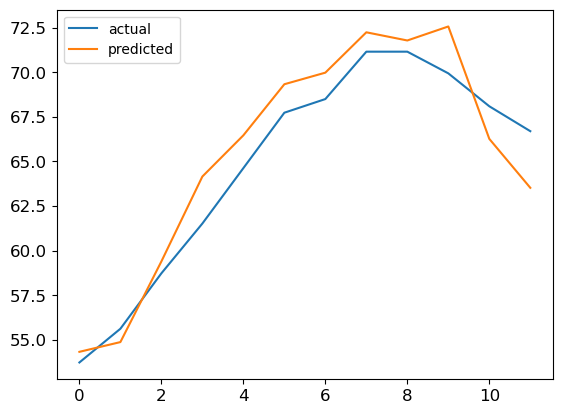

In [225]:
# Plot a random row to see the accuracy of predictions

random_row = np.random.randint(low=0, high=86)

plt.plot(actual.iloc[random_row], label='actual')
plt.plot(predicted.iloc[random_row], label='predicted')

plt.legend()
plt.show()

# Sliding window

Prior 18 hours predicts next 6 hours

In [226]:
steps_for_prediction = 18
steps_to_predict = 6

#Be careful: sums to 24 hours

In [227]:
train

array([[ 3.91231634e-01,  3.25682833e-01,  2.84168591e-01, ...,
         8.19483803e-01,  7.33021812e-01,  4.70826607e-01],
       [ 1.40585504e-01, -1.61251120e-01, -3.10452678e-01, ...,
         1.05670804e+00,  1.03048851e+00,  8.17610980e-01],
       [ 6.42189902e-01,  4.37427933e-01,  2.47648545e-01, ...,
         1.02549432e+00,  9.70558182e-01,  8.08559002e-01],
       ...,
       [-1.70539360e+00, -1.73348594e+00, -1.78498857e+00, ...,
        -4.92740772e-01, -1.10609027e+00, -1.46192662e+00],
       [-1.65857302e+00, -1.77094240e+00, -1.75221417e+00, ...,
         3.59393645e-01, -2.25863510e-01, -5.77017803e-01],
       [-8.29848893e-01, -9.74992668e-01, -1.04054147e+00, ...,
         4.85809190e-01, -1.12476250e-03, -4.83376658e-01]])

In [228]:
train.flatten().shape

(4824,)

In [229]:
train_inputs_sw = []
train_target_sw = []

for i in range(0,4824-24):
    input_row = train.flatten()[i:i+steps_for_prediction]
    target_row = train.flatten()[i+steps_for_prediction:i+steps_for_prediction+steps_to_predict]
    train_inputs_sw.append((input_row))
    train_target_sw.append((target_row))

In [230]:
train_inputs = np.vstack(train_inputs_sw)

train_targets = np.vstack(train_target_sw)

In [231]:
train_targets.shape

(4800, 6)

In [232]:
# Repeat for test

test_inputs_sw = []
test_target_sw = []

for i in range(0,test.flatten().shape[0]-24):
    input_row = test.flatten()[i:i+steps_for_prediction]
    target_row = test.flatten()[i+steps_for_prediction:i+steps_for_prediction+steps_to_predict]
    test_inputs_sw.append((input_row))
    test_target_sw.append((target_row))
    
test_inputs = np.vstack(test_inputs_sw)

test_targets = np.vstack(test_target_sw)

# GRU

In [233]:
model = keras.models.Sequential([
    keras.layers.GRU(32, activation='relu', return_sequences=True, input_shape=[18, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(steps_to_predict, activation=None)
])

In [234]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_inputs, train_targets, epochs=30)

Epoch 1/30
150/150 [==============================] - 1s 4ms/step - loss: 0.3256
Epoch 2/30
150/150 [==============================] - 1s 4ms/step - loss: 0.1130
Epoch 3/30
150/150 [==============================] - 1s 4ms/step - loss: 0.0900
Epoch 4/30
150/150 [==============================] - 1s 4ms/step - loss: 0.0783
Epoch 5/30
150/150 [==============================] - 1s 4ms/step - loss: 0.0747
Epoch 6/30
150/150 [==============================] - 1s 4ms/step - loss: 0.0739
Epoch 7/30
150/150 [==============================] - 1s 4ms/step - loss: 0.0722
Epoch 8/30
150/150 [==============================] - 1s 4ms/step - loss: 0.0691
Epoch 9/30
150/150 [==============================] - 1s 4ms/step - loss: 0.0682
Epoch 10/30
150/150 [==============================] - 1s 4ms/step - loss: 0.0682
Epoch 11/30
150/150 [==============================] - 1s 4ms/step - loss: 0.0661
Epoch 12/30
150/150 [==============================] - 1s 4ms/step - loss: 0.0663
Epoch 13/30
150/150 [====

### Predictions

In [235]:
#Predict:
y_pred = model.predict(test_inputs)

65/65 [==============================] - 0s 1ms/step


In [236]:
#Remember, these are standardized values. 

actual = pd.DataFrame(scaler.inverse_transform(test_targets))
predicted = pd.DataFrame(scaler.inverse_transform(y_pred))

In [237]:
actual

,0,1,2,3,4,5
0,75.560,80.285,80.465,80.150,74.075,70.880
1,80.285,80.465,80.150,74.075,70.880,69.575
2,80.465,80.150,74.075,70.880,69.575,69.035
3,80.150,74.075,70.880,69.575,69.035,68.495
4,74.075,70.880,69.575,69.035,68.495,67.955
...,...,...,...,...,...,...
2059,72.464,73.976,74.930,78.485,79.916,81.635
2060,73.976,74.930,78.485,79.916,81.635,83.075
2061,74.930,78.485,79.916,81.635,83.075,83.435
2062,78.485,79.916,81.635,83.075,83.435,83.192


In [238]:
predicted

,0,1,2,3,4,5
0,74.450829,74.109627,72.814156,70.147057,69.042030,67.645096
1,74.436836,73.427658,71.712692,69.467972,68.646873,67.159164
2,80.510246,79.213867,76.640762,73.303375,72.688629,70.071884
3,77.838287,76.041611,74.515335,72.329369,70.805847,69.024658
4,77.520264,75.623352,73.277161,71.752380,70.893066,69.203506
...,...,...,...,...,...,...
2059,71.980194,74.350426,76.066582,78.182251,80.843307,83.823936
2060,74.241951,76.493683,78.070953,80.377075,82.186920,83.812828
2061,75.741631,77.942810,79.615410,81.415482,82.785332,83.448853
2062,76.214874,78.455406,80.046600,81.253105,82.175125,82.503334


In [239]:
mean_squared_error(actual, predicted)

14.297701739145248

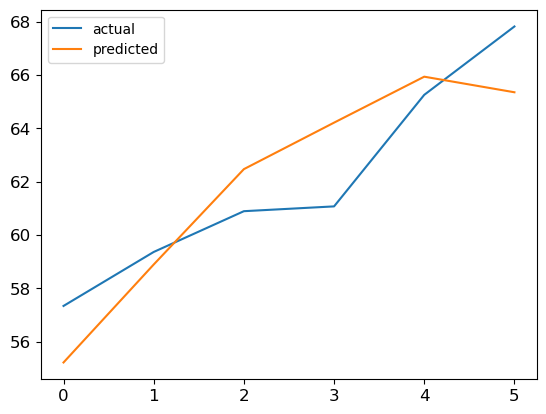

In [240]:
# Plot a random row to see the accuracy of predictions

random_row = np.random.randint(low=0, high=2063)

plt.plot(actual.iloc[random_row], label='actual')
plt.plot(predicted.iloc[random_row], label='predicted')

plt.legend()
plt.show()

## We could try using 6 steps to predict the next 6 steps (maybe 12 steps is too long)